In [118]:
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random
from matplotlib import colors
import copy
import time
import scipy.optimize

%matplotlib inline

The functions below form the core of the simulation. Note that we haven't bothered to write a function for computing magnetization, because the magnetization is just the sum of the spins on the lattice.

In [21]:
# assumes periodic BCs
def metropolis_ising(init, boltz):
    """Returns a mesh evolved by one step of applying the Metropolis algorithm, the energy change, 
    and the magnetization change"""
    
    mesh = copy.copy(init)
    
    X = np.shape(mesh)[1]
    Y = np.shape(mesh)[0]
    
    # select random spin from the input spin mesh
    x = random.choice(range(X))
    y = random.choice(range(Y))
    
    # applying the metropolis algorithm
    spin_sum = (mesh[(y+1) % Y,x ] + mesh[y ,(x+1) % X] + mesh[(y-1) % Y,x ] + mesh[y ,(x-1) % X])
    d_energy = 2*mesh[y,x] * spin_sum
    
    if d_energy <= 0:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
        mesh[y,x] = -1*mesh[y,x]
        d_mag = 2*mesh[y,x]
        
    else:
        d_energy = 0
        d_mag = 0
        

    return [mesh, d_energy, d_mag]

In [4]:
def plot_ising_grid(init, title):
    """Creates a discrete colormap for an input Ising grid, red for up (1) and blue for down (-1)"""
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [0,1,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(6,6))
    plt.imshow(init, cmap=cmap, norm=norm)
    plt.title(title, fontsize=20)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    display.clear_output(wait = True)

    plt.show()

In [23]:
def mc_step(init, boltz, n, plot = False, final_only = False):
    """Plots n-step evolution of an Ising model using Metropolis and returns the final grid"""
    
    grid = init[:,:]
    
    for i in range(n):    
        # evolve using metropolis
        evo = metropolis_ising(grid, boltz)[0]
        
        if plot == True:
            # plotting
            if final_only == False:    
                plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')


            else:
                if i == n-1:
                    plot_ising_grid(evo, f'2D Ising Model; n = {i+1}')
        
        # reset iteration variable
        grid = evo[:,:]
        
    return grid

In [3]:
# variant of the above that only returns the grid after 1 sweep
# faster than the single-step program when simulating for very long times
def mc_sweep(init, boltz):
    
    grid = init[:,:]
    
    X = np.shape(grid)[1]
    Y = np.shape(grid)[0]
    
    for j in range(X):
        for i in range(Y):
            x = np.random.randint(X)
            y = np.random.randint(Y)
            spin = grid[y,x]
            
            spin_sum = grid[(y+1) % Y,x ] + grid[y ,(x+1) % X] + grid[(y-1) % Y,x ] + grid[y ,(x-1) % X]
            d_energy = 2 * spin * spin_sum

            if d_energy <= 0:
                grid[y,x] = -1*grid[y,x]
              #  d_mag = 2*grid[y,x]

            elif random.uniform(0,1) < boltz[str(abs(spin_sum))]:
                grid[y,x] = -1*grid[y,x]
            #    d_mag = 2*grid[y,x]

           # else:
           #     d_energy = 0
           #     d_mag = 0
        
    return grid
                
    

In [6]:
def ising_energy(init):
    """Computes the energy of a 2D square lattice in the Ising model"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    
    energy = 0
    
    for i in range(Y):
        for j in range(X):
            energy += -1 * init[i,j] * (init[(i+1) % Y ,j] + init[(i-1) % Y,j] + init[i,(j+1) % X] + init[i,(j-1) % X])
            
    energy = energy/2
    
    return energy

The following functions are auxiliary; they are used to check various properties of the simulation, like equilibration time or thermodynamic properties.

In [7]:
def energy_evo(init, boltz, n, plot = True):
    """Returns a list of energies for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # energy
    energy = ising_energy(grid)
    energy_list = [energy]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment energy
        energy += d_energy
        energy_list.append(energy)
    
        # reset iteration variable
        grid = evo[:,:]
    
    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,energy_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Energy', fontsize=20)
        plt.title(f'Energy of Ising Grid', fontsize=20)

    return energy_list


In [249]:
def magps(init, boltz, n, plot = True):
    """Returns a list of mag. per spin for a 2D Ising grid from every timestep and plots the list"""

    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    grid = init[:,:]
    
    # magnetization
    mag = np.sum(grid)
    mag_list = [mag/total]
    
    # evolution
    for i in range(n):
        evo, d_energy, d_mag = metropolis_ising(grid, boltz)
        
        # increment magnetization
        mag += d_mag
        mag_list.append(mag/total)
    
        # reset iteration variable
        grid = evo[:,:]

    if plot == True:
        # plotting
        x_axis = [i/total for i in range(n+1)]

        plt.figure(figsize=(6,6))
        plt.plot(x_axis,mag_list)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Sweeps', fontsize=20)
        plt.ylabel('Magnetization per Spin', fontsize=20)
        plt.title(f'Magnetization per Spin of Ising Grid', fontsize=20)
    
    
    return mag_list

In [250]:
def auto_cor_m(init, boltz, n):
    """Compute the time auto-correlation value using the magnetization per spin"""
    
    X = np.shape(init)[1]
    Y = np.shape(init)[0]
    total = X*Y
    
    mag_list = magps(init, boltz, n, plot = False)
    
    mag_mean = np.mean(mag_list)
    m_mean2 = mag_mean**2
    
    auto_cor = []
    
    for i in range(len(mag_list)-1):
        
        auto_cor.append(mag_list[i]*mag_list[i+1] - m_mean2)
        
    # plotting
    x_axis = [i/total for i in range(len(auto_cor))]

    plt.figure(figsize=(6,6))
    plt.plot(x_axis,auto_cor)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xlabel('Sweeps', fontsize=20)
    plt.title(f'Magnetization Autocorrelation', fontsize=20)
    
    
    
    

The following function are measurements that involve means. To get accurate means, one should probably sample with a frequency no greater than once per sweep, i.e. once per N number of MC steps, where N is the number of spins on the lattice.

In [9]:
# keep in mind sampling frequency for the energies in energy_list
def spec_heat_ps(energy_list, T, N):
    """Compute the specific heat per spin for an input list of energy values at temperature T and lattice sites N"""
    
    if type(energy_list) is list:
        energy_list = np.array(energy_list)
    
    moment_1 = np.mean(energy_list)
    moment_2 = np.mean(np.square(energy_list))
    
    c = (1/(T**2 * N)) * (moment_2 - moment_1**2)
    
    return c

In [10]:
def sus(mag_list, T, N):
    """Compute susceptibility for an input list of mag per spin values at temperature T and lattice sites N"""
    
    if type(mag_list) is list:
        mag_list = np.array(mag_list)
    
    moment_1 = np.mean(mag_list)
    
    moment_2 = np.mean(np.square(mag_list))
    
    chi = (N/T) * (moment_2 - moment_1**2)
    
    return chi

In [78]:
def ss_cor(init, boltz, n_sweep, n_equil, s1, s2):
    """Compute the mean correlation between spins s1 and s2"""
    
    grid = init[:,:]
    
    cor = 0
    
    # evolve to equilibrium
    for i in range(n_equil):
        mc_sweep(grid, boltz)
        
    # set the equilibrium value after which measurements will be made
    for j in range(n_sweep):
        mc_sweep(grid, boltz)
        cor += grid[s1[0],s1[1]] * grid[s2[0],s2[1]]
    
        
    cor = cor/(n_sweep)
    
    return cor

In [11]:
# c_list is a list of specific heats per spin computed at the evenly-spaced, 
# ascending-ordered temperatures on temp_list
# s_0 is the entropy per spin at the the minimum of temp_list 
def ent_ps(temp_list, c_list, s_0):
    """Compute the entropy of an Ising lattice using the trapezoidal rule for a given set of temperatures and c"""
    
    dT = temp_list[1] - temp_list[0]
    n = len(temp_list)
    
    # compute the boundary terms
    t_min = temp_list[0]
    t_max = temp_list[-1]
    
    c_1 = c_list[0]
    c_2 = c_list[-1]
    
    boundary = (c_2/t_max + c_1/t_min)
    
    
    # initialize the integral sum
    integral = boundary
    
    for i in range(1,n-1):
        integral += c_list[i]/temp_list[i]
        
    integral = integral*dT
    
    # include the integration constant
    s = s_0 + integral
    
    return s
    

Below is some code used to explore the temperature range around the critical temperature, as well as a rudimentary attempt to obtain a value for the critical temperature and critcal exponents. Because the efforts are rudimentary and the computations take a lot of time, there has been no attempt to modularize the code.

In [563]:
# exploring the temperature range around the critical temp

temps = [t for t in np.arange(1.5, 3.01, .01)]
t_points = len(temps)

# initialize lists
eneps_list8 = np.zeros(t_points)
magps_list8 = np.zeros(t_points)
spec_heat8 = np.zeros(t_points)
mag_sus8 = np.zeros(t_points)

In [565]:
# initialize to T = 0
test = 1*np.ones((8,8))      
init = test[:,:]

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*8

# number of sweeps to average over
n = 50*8

# factors for averaging
n1 = 1/(n * 8**2)
n2 = 1/(n**2 * 8**2)

In [566]:
start = time.time()

grid = copy.copy(init)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        mc_sweep(grid, boltz)         # fewer function calls than stepping n_eq * N times, so faster
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        mc_sweep(grid, boltz)
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy               # faster than squaring using **2 I think?
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list8[i] = n1*e_total
    magps_list8[i] = n1*mag_total
    spec_heat8[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus8[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print(end - start)    

100.08581900596619


Text(0,0.5,'Susceptibility')

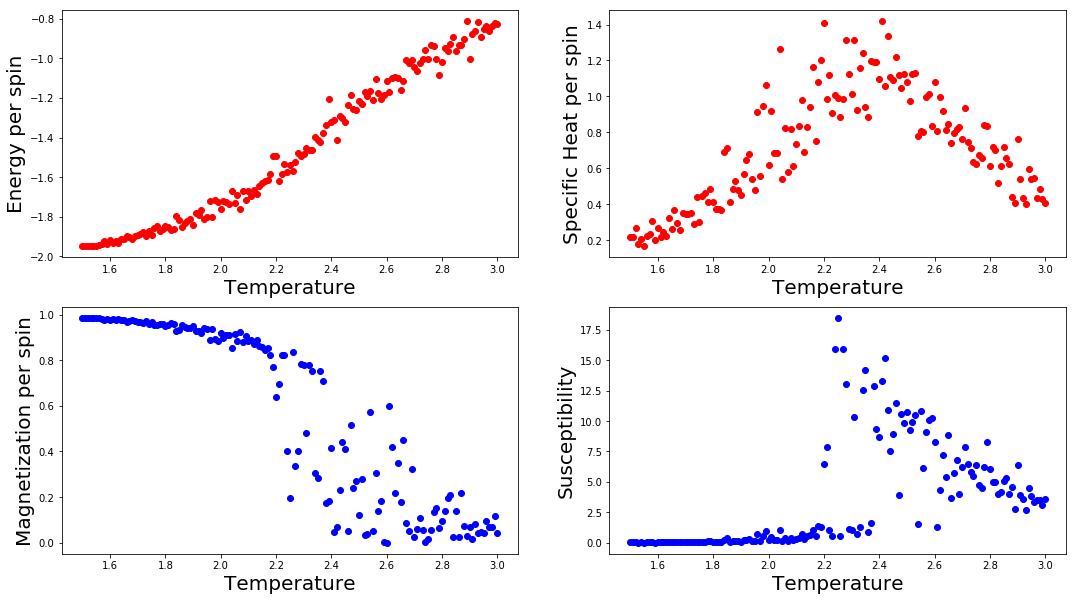

In [621]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat8, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list8), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus8, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [563]:
# exploring the temperature range around the critical temp

temps = [t for t in np.arange(1.5, 3.01, .01)]
t_points = len(temps)

# initialize lists
eneps_list10 = np.zeros(t_points)
magps_list10 = np.zeros(t_points)
spec_heat10 = np.zeros(t_points)
mag_sus10 = np.zeros(t_points)

In [565]:
# initialize to T = 0
test = 1*np.ones((10,10))      
init = test[:,:]

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*10

# number of sweeps to average over
n = 50*10

# factors for averaging
n1 = 1/(n * 10**2)
n2 = 1/(n**2 * 10**2)

In [566]:
start = time.time()

grid = copy.copy(init)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        mc_sweep(grid, boltz)         # fewer function calls than stepping n_eq * N times, so faster
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        mc_sweep(grid, boltz)
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy               # faster than squaring using **2 I think?
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list10[i] = n1*e_total
    magps_list10[i] = n1*mag_total
    spec_heat10[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus10[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print(end - start)    

100.08581900596619


Text(0,0.5,'Susceptibility')

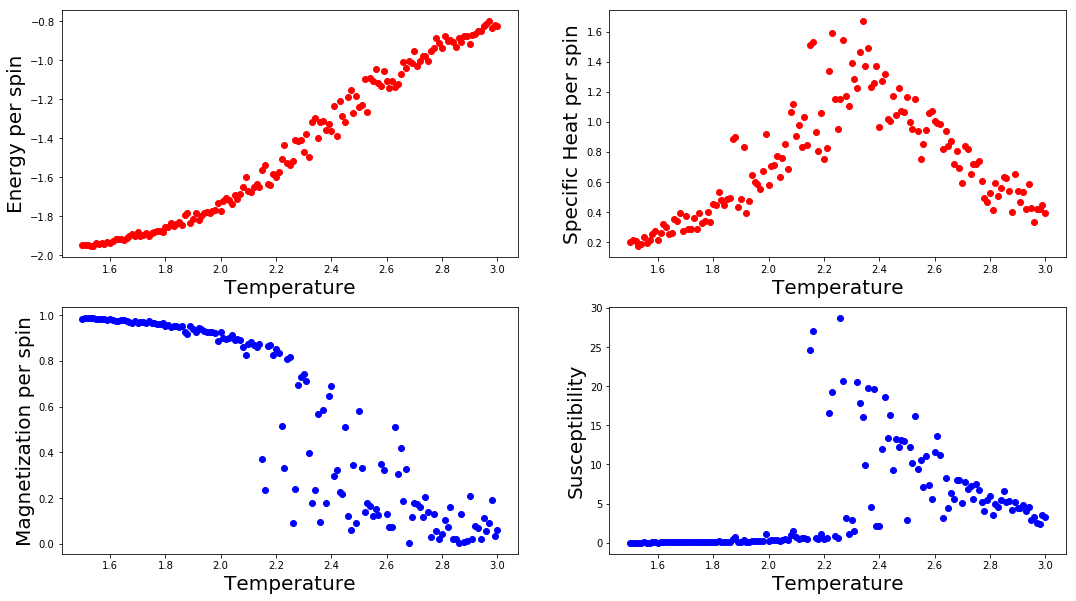

In [620]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list10, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat10, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list10), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus10, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [568]:
np.save('eneps_list10', eneps_list10)
np.save('spec_heat10', spec_heat10)
np.save('magps_list10', magps_list10)
np.save('mag_sus10', mag_sus10)

In [592]:
# exploring the temperature range around the critical temp

temps = [t for t in np.arange(1.5, 3.01, .01)]
t_points = len(temps)

# initialize lists
eneps_list15 = np.zeros(t_points)
magps_list15 = np.zeros(t_points)
spec_heat15 = np.zeros(t_points)
mag_sus15 = np.zeros(t_points)

In [593]:
# initialize to T = 0
test = 1*np.ones((15,15))      
init = test[:,:]

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*15

# number of sweeps to average over
n = 50*15

# factors for averaging
n1 = 1/(n * 15**2)
n2 = 1/(n**2 * 15**2)

In [594]:
start = time.time()

grid = copy.copy(init)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        mc_sweep(grid, boltz)         # fewer function calls than stepping n_eq * N times, so faster
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        mc_sweep(grid, boltz)
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy               # faster than squaring using **2 I think?
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list15[i] = n1*e_total
    magps_list15[i] = n1*mag_total
    spec_heat15[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus15[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print(end - start)    

328.969895362854


Text(0,0.5,'Susceptibility')

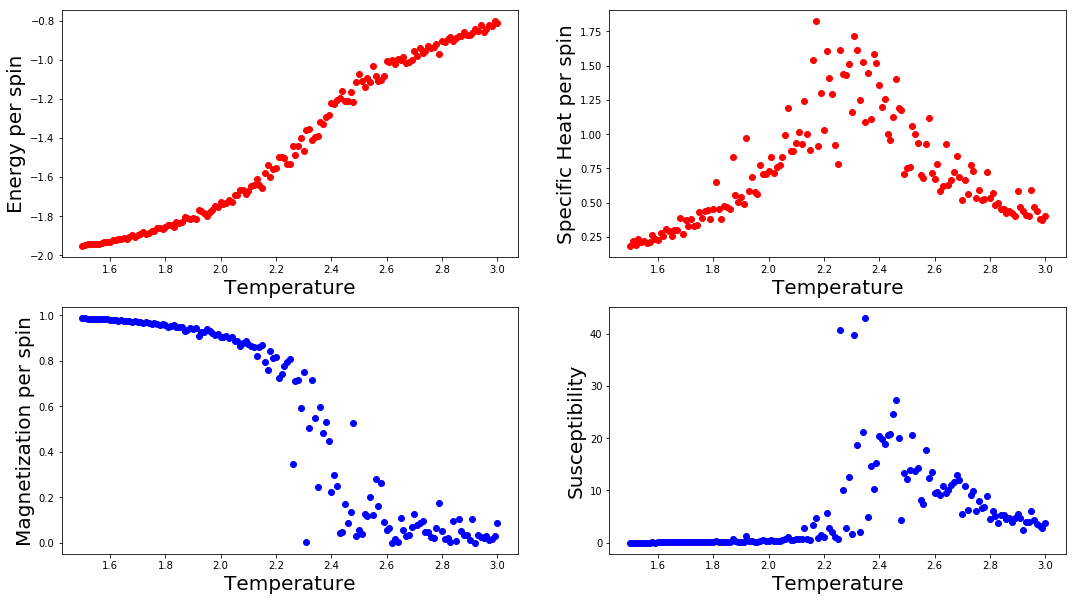

In [595]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list15, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat15, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list15), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus15, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [600]:
np.save('eneps_list15new', eneps_list15)
np.save('spec_heat15new', spec_heat15)
np.save('magps_list15new', magps_list15)
np.save('mag_sus15new', mag_sus15)

Below is the largest lattice we consider near the critical temperature, due to the slow speed of the program.

In [555]:
# exploring the temperature range around the critical temp

temps = [t for t in np.arange(1.5, 3.01, .01)]
t_points = len(temps)

# initialize lists
eneps_list30 = np.zeros(t_points)
magps_list30 = np.zeros(t_points)
spec_heat30 = np.zeros(t_points)
mag_sus30 = np.zeros(t_points)

In [556]:
# initialize to T = 0
test = 1*np.ones((30,30))      
init = test[:,:]

# rough estimate for equilibration time; 100*N many sweeps
n_eq = 100*30

# number of sweeps to average over
n = 50*30

# factors for averaging
n1 = 1/(n * 30**2)
n2 = 1/(n**2 * 30**2)

In [557]:
start = time.time()

grid = copy.copy(init)

for i in range(t_points):
    T = temps[i]
    boltz = {"4.0" : np.exp(-8/T), "2.0" : np.exp(-4/T)}
    
    for j in range(n_eq):
        mc_sweep(grid, boltz)         # fewer function calls than stepping n_eq * N times, so faster
    
    # initialize the totals that will be used to compute averages
    e_total = 0
    e2_total = 0
    mag_total = 0
    mag2_total= 0
    
    # measurements to average
    for k in range(n):
        mc_sweep(grid, boltz)
        energy = ising_energy(grid)             # only taking measurements every sweep
        mag = np.sum(grid)
        
        e_total += energy
        e2_total += energy*energy               # faster than squaring using **2 I think?
        mag_total += mag
        mag2_total += mag*mag
    
    # compute averages
    eneps_list30[i] = n1*e_total
    magps_list30[i] = n1*mag_total
    spec_heat30[i] = (n1*e2_total - n2*e_total*e_total)/(T*T)
    mag_sus30[i] = (n1*mag2_total - n2*mag_total*mag_total)/T
        
        
end = time.time()
print(end - start)    

3455.4794566631317


Text(0,0.5,'Susceptibility')

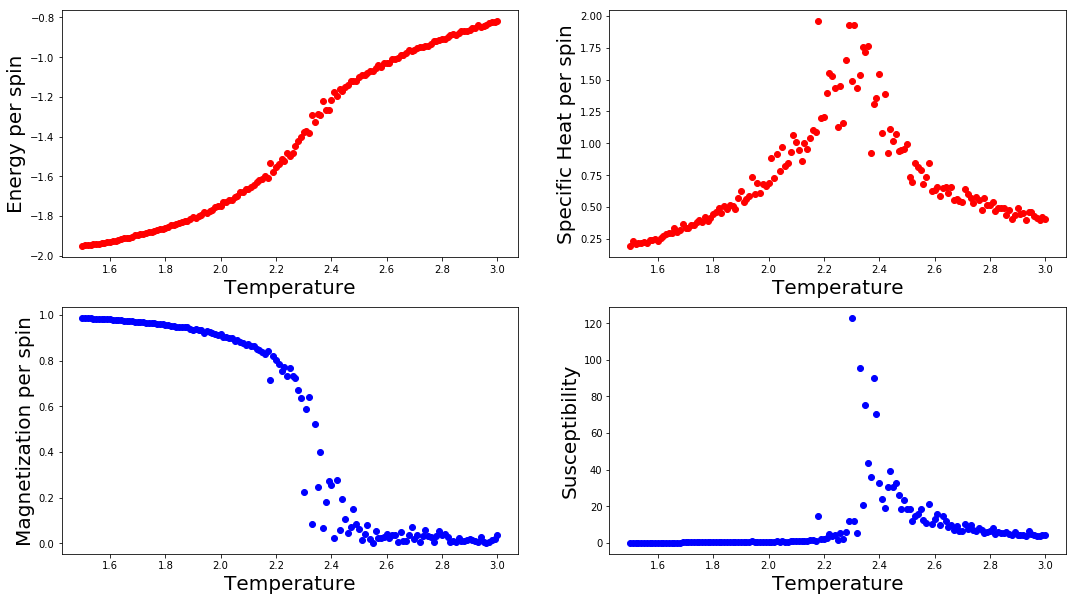

In [558]:
fig = plt.figure(figsize=(18, 10)) # plot the calculated values    

fig.add_subplot(2, 2, 1 )
plt.plot(temps, eneps_list30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Energy per spin", fontsize=20)

fig.add_subplot(2, 2, 2 )
plt.plot(temps, spec_heat30, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

fig.add_subplot(2, 2, 3 )
plt.plot(temps, abs(magps_list30), 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

fig.add_subplot(2, 2, 4 )
plt.plot(temps, mag_sus30, 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [559]:
np.save('eneps_list30', eneps_list30)
np.save('spec_heat30', spec_heat30)
np.save('magps_list30', magps_list30)
np.save('mag_sus30', mag_sus30)

In [632]:
i8s = np.argmax(spec_heat8)
i10s = np.argmax(spec_heat10)
i15s = np.argmax(spec_heat15)
i30s = np.argmax(spec_heat30)

i8m = np.argmax(mag_sus8)
i10m = np.argmax(mag_sus10)
i15m = np.argmax(mag_sus15)
i30m = np.argmax(mag_sus30)

In [633]:
# crit temp for each lattice size
crit_temp = []

crit_temp.append(temps[i8s] + temps[i8m])
crit_temp.append(temps[i10s] + temps[i10m])
crit_temp.append(temps[i15s] + temps[i15m])
crit_temp.append(temps[i30s] + temps[i30m])

crit_temp = np.array(crit_temp)/2

Text(0,0.5,'$T_c$')

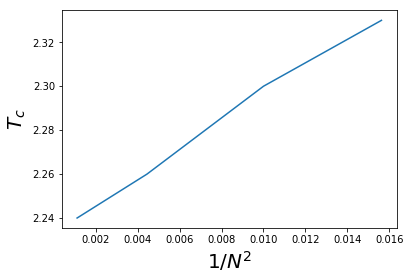

In [638]:
plt.plot([1/64, 1/100, 1/225, 1/900], crit_temp)
plt.xlabel("$1/N^2$", fontsize=20)
plt.ylabel("$T_c$", fontsize=20)

In [590]:
def lin(x, a, b):
    return a*x + b

In [635]:
scipy.optimize.curve_fit(lin, [1/64, 1/100, 1/225, 1/900], crit_temp)

(array([6.3074933 , 2.23333221]), array([[ 7.55672292e-02, -5.89057093e-04],
        [-5.89057093e-04,  6.89793229e-06]]))

We see that the simulations predict a critical temperature of 2.23, which is pretty close to the actual value of 2.269. The error is almost certainly due to errors in the simulation and the general instability of the simulation around the critical temperature, as can be seen from the plots. There is also the issue of our temperature resolution being finite, and our determination of the critical temperature for each lattice size.

Text(0,0.5,'Magnetization per spin')

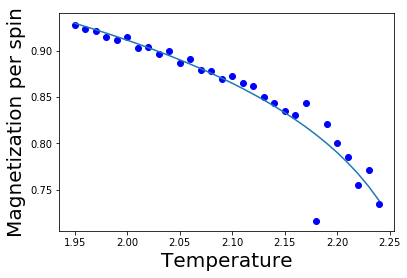

In [704]:
plt.plot(temps[45:75], abs(magps_list30)[45:75], 'bo')
plt.plot(temps[45:75], f_mag)
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Magnetization per spin", fontsize=20)

In [668]:
def power(x, a, b, c):
    return a*((b-x)/b)**c

In [702]:
f_mag = power(np.array(temps[45:75]), 1.18381491, 2.29653853, 0.127514)

In [701]:
scipy.optimize.curve_fit(power, temps[45:75], abs(magps_list30)[45:75], p0 = [1, 2.35, 0.125], maxfev=10000)

C:\Users\Newton\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


(array([1.18381491, 2.29653853, 0.127514  ]),
 array([[0.00524271, 0.0025688 , 0.00250166],
        [0.0025688 , 0.00145031, 0.00128425],
        [0.00250166, 0.00128425, 0.0012144 ]]))

We found great values for the critical temperature and the critical exponent of the magnetization! Unfortunately the error is fairly large, and also it is very subject to which set of points we look at, so not super reliable.

Text(0,0.5,'Specific Heat per spin')

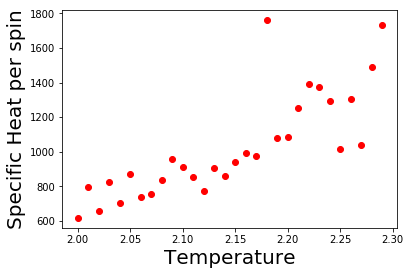

In [838]:
plt.plot(temps[50:80], np.array(spec_heat30[50:80])*900, 'ro')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Specific Heat per spin", fontsize=20)

In [837]:
scipy.optimize.curve_fit(power, temps[50:80], np.array(spec_heat30[50:80])*900, p0 = [1, 2.3, .01], maxfev=10000)

(array([   3.21416432,  230.66193586, -614.27145182]),
 array([[ 5.46128493e+03, -1.43025992e+07,  3.84495876e+07],
        [-1.43025992e+07,  3.75085408e+10, -1.00833334e+11],
        [ 3.84495876e+07, -1.00833334e+11,  2.71067905e+11]]))

In [787]:
f_spec = power(np.array(temps[50:80]), 1, 2.27, -.01)

C:\Users\Newton\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


Need to think about what's going on with the specific heat per spin...

Text(0,0.5,'Susceptibility')

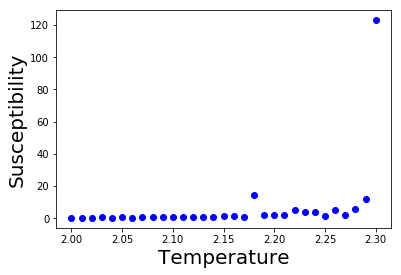

In [828]:
plt.plot(temps[50:81], mag_sus30[50:81], 'bo')
plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Susceptibility", fontsize=20)

In [833]:
scipy.optimize.curve_fit(power, temps[50:80], mag_sus30[50:80], p0 = [.01, 2.3, -1.75], maxfev=10000)

(array([ 0.4470493,  2.2939991, -0.5132618]),
 array([[ 1.91509067e-01, -2.70283751e-03,  1.20678843e-01],
        [-2.70283751e-03,  5.35300620e-05, -1.93411547e-03],
        [ 1.20678843e-01, -1.93411547e-03,  8.03797039e-02]]))

The susceptibility critical exponent cannot be obtained from this data; it the temperature resolution is too coarse when combined with instabilities in the simulation. Unfortunately, we cannot do the simulation again to get a better set of data -- the program takes over an hour to run! Fortunately, we have the Wolff algorithm...


In sum: we were able to obtain the critical exponent for the magnetization per spin, as well as the critical temperature to decent accuracy. However, we have bad luck with our simulation and were unable to obtain the critical exponents for the heat capacity and the susceptibility. Normally we would run the simulation again, but it takes over an hour to run the same simulation! We therefore see the primary weakness of the Metropolis algorithm: it is VERY slow near the critical temperature, and not useful if we need to run simulations more than once.